In [1]:
#Download Index file
!irsx_index --year=2021 --verbose

Getting index file for year: 2021 remote=https://s3.amazonaws.com/irs-form-990/index_2021.csv local=/opt/conda/miniconda3/lib/python3.8/site-packages/irsx/CSV/index_2021.csv
Beginning streaming download of https://s3.amazonaws.com/irs-form-990/index_2021.csv
Total file size: 55.76 MB
Download completed to /opt/conda/miniconda3/lib/python3.8/site-packages/irsx/CSV/index_2021.csv in 0:00:07.584222


In [2]:
# To have time runtime for cells
try:
    %load_ext autotime
except:
    !pip install ipython-autotime
    %load_ext autotime

time: 382 µs (started: 2022-02-06 10:00:13 +00:00)


In [1]:
from pyspark.sql.session import SparkSession
import pandas as pd
from pyspark.sql.types import StringType

spark = SparkSession.builder.getOrCreate()

path = "/opt/conda/miniconda3/lib/python3.8/site-packages/irsx/CSV/index_2021.csv"
df21 = pd.read_csv(path, index_col=False, dtype=str) # read all as string, not beautiful but we only need object id anyways

sdf = spark.createDataFrame(df21["OBJECT_ID"], StringType())

In [2]:
from irsx.xmlrunner import XMLRunner
from pyspark.sql.types import StringType, StructType, StructField, IntegerType
from pyspark.sql.functions import udf

xml_runner = XMLRunner()
def transform_data(e):
    try:
        filing = xml_runner.run_filing(e)
        schedules = filing.list_schedules()
    except:
        print(f"Transform error for id {e}")
        return ["","","","",0, 0, 0, 0, 0, 0,0, 0]
    
    ein = 0
    state = 0
    name = 0
    revenue = 0
    revenueEZ = 0
    vol_cnt, empl_cnt, rvn_ls_exp, liab_eoy, liab_boy,assts_eoy, assts_boy = 0, 0, 0, 0, 0,0, 0
    
    if "ReturnHeader990x" in schedules:
        header = filing.get_parsed_sked("ReturnHeader990x")
        header_part_i = header[0]["schedule_parts"]["returnheader990x_part_i"]
        ein = header_part_i["ein"]
        state = header_part_i.get("USAddrss_SttAbbrvtnCd", "XX")
        name = header_part_i["BsnssNm_BsnssNmLn1Txt"]
        
    if "IRS990EZ" in schedules:
        irs990ez = filing.get_parsed_sked("IRS990EZ")
        irs990ez_part_i = irs990ez[0]["schedule_parts"].get("ez_part_i", None)
        if irs990ez_part_i:
            revenueEZ = irs990ez_part_i.get("TtlRvnAmt", 0)        
    
    if "IRS990" in schedules:
        irs990 = filing.get_parsed_sked("IRS990")
        irs990_part_i = irs990[0]["schedule_parts"]["part_i"]
        revenue = irs990_part_i["CYTtlRvnAmt"]
        vol_cnt = int(irs990_part_i.get("TtlVlntrsCnt", 0))
        empl_cnt = int(irs990_part_i.get("TtlEmplyCnt", 0))
        rvn_ls_exp = int(irs990_part_i.get("CYRvnsLssExpnssAmt", 0))
        liab_eoy = int(irs990_part_i.get("TtlLbltsEOYAmt", 0))
        liab_boy = int(irs990_part_i.get("TtlLbltsBOYAmt", 0))
        assts_eoy = int(irs990_part_i.get("TtlAsstsEOYAmt", 0))
        assts_boy = int(irs990_part_i.get("TtlAsstsBOYAmt", 0))



    
    revenue = int(revenue) + int(revenueEZ)
    return [e, ein, state, name, revenue, vol_cnt, empl_cnt, rvn_ls_exp, liab_eoy, liab_boy,assts_eoy, assts_boy ]
     
    
my_schema = StructType([
    StructField("ObjectID", StringType(), nullable=False),
    StructField("EIN", StringType(), nullable=False),
    StructField("State", StringType(), nullable=False),
    StructField("Name", StringType(), nullable=False),
    StructField("Revenue", IntegerType(), nullable=False),
    StructField("TtlVlntrsCnt", IntegerType(), nullable=False),
    StructField("TtlEmplyCnt", IntegerType(), nullable=False),
    StructField("CYRvnsLssExpnssAmt", IntegerType(), nullable=False),
    StructField("TtlLbltsEOYAmt", IntegerType(), nullable=False),
    StructField("TtlLbltsBOYAmt", IntegerType(), nullable=False),
    StructField("TtlAsstsEOYAmt", IntegerType(), nullable=False),
    StructField("TtlAsstsBOYAmt", IntegerType(), nullable=False),
])

spark_transform_data = udf(lambda z: transform_data(z), my_schema)
spark.udf.register("spark_transform_data", spark_transform_data)

<function __main__.<lambda>(z)>

In [15]:
from irsx.xmlrunner import XMLRunner
# Try to find out how many tags are in that file, not working
xml_runner = XMLRunner()
filing = xml_runner.run_filing("202021359349301552")

def recurse(dict):
    result = []
    for key in dict:
        result.append(key)
        result.extend(recurse(dict[key]))
    return result

for e in filing.list_schedules():
    childs = recurse(filing.get_parsed_sked(e)[0])
    print(recurse)

TypeError: string indices must be integers

In [23]:
transform_data("202032549349200018")

['202032549349200018',
 '223697708',
 'NJ',
 'NUTLEY LINCOLN SCHOOL P T O',
 90267,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

time: 7.11 ms (started: 2022-02-02 11:16:45 +00:00)


In [ ]:
# Sample
small_sdf = sdf.sample(0.4, seed=43).repartition(10)
anz = small_sdf.count()
print(anz)
small_sdf2 = small_sdf.withColumn('valuelist', spark_transform_data('value')).select("valuelist.*")
#small_sdf2.show()
small_sdf.explain()
small_sdf2.toPandas().to_csv(f"BIGData/{anz}.csv", index=None)

In [38]:
# full df
anz = sdf.count()
print(anz)
sdf2 = sdf.withColumn('valuelist', spark_transform_data('value')).select("valuelist.*")
sdf2.explain()
pdf = sdf2.toPandas()
pdf.to_csv(f"hdfs://big-spark-cluster-m/user/root/{anz}.csv", index=False)
pdf.to_parquet(f"hdfs://big-spark-cluster-m/user/root/{anz}.parquet", index=False)


22/02/02 11:34:35 WARN org.apache.spark.scheduler.TaskSetManager: Stage 45 contains a task of very large size (2076 KiB). The maximum recommended task size is 1000 KiB.


184781
== Physical Plan ==
*(2) Project [pythonUDF0#721.ObjectID AS ObjectID#697, pythonUDF0#721.EIN AS EIN#698, pythonUDF0#721.State AS State#699, pythonUDF0#721.Name AS Name#700, pythonUDF0#721.Revenue AS Revenue#701, pythonUDF0#721.TtlVlntrsCnt AS TtlVlntrsCnt#702, pythonUDF0#721.TtlEmplyCnt AS TtlEmplyCnt#703, pythonUDF0#721.CYRvnsLssExpnssAmt AS CYRvnsLssExpnssAmt#704, pythonUDF0#721.TtlLbltsEOYAmt AS TtlLbltsEOYAmt#705, pythonUDF0#721.TtlLbltsBOYAmt AS TtlLbltsBOYAmt#706, pythonUDF0#721.TtlAsstsEOYAmt AS TtlAsstsEOYAmt#707, pythonUDF0#721.TtlAsstsBOYAmt AS TtlAsstsBOYAmt#708]
+- BatchEvalPython [<lambda>(value#685)], [pythonUDF0#721]
   +- *(1) Scan ExistingRDD[value#685]




22/02/02 11:34:36 WARN org.apache.spark.scheduler.TaskSetManager: Stage 48 contains a task of very large size (2076 KiB). The maximum recommended task size is 1000 KiB.


time: 14min 23s (started: 2022-02-02 11:34:34 +00:00)


### Zeiten von erfolgreichen Läufen

|Anzahl | Zeit| Kommentar |  
-------|--------|---------------
|4710 | time: 2min 44s (started: 2022-01-17 18:46:15 +00:00) | erster Versuch (zusätzlicher Zeitbedarf für Sampling  & lokal)|
|46099| time: 12min 22s (started: 2022-01-17 20:42:31 +00:00) | erster Versuch mit ErrorHandling (zusätzlicher Zeitbedarf für Sampling & lokal)|
|184781| time: 1h 14min 7s (started: 2022-01-25 12:37:15 +00:00) | -  (zusätzlicher Zeitbedarf für Sampling & lokal)|
|184781| time: 14min 23s (started: 2022-02-02 11:34:34 +00:00) | mehr Attribute, dafür kein Samplen mehr sonder direkt beim Einlesen, speichern in HDFS|

## Start a Sparkession

## Einlesen des Files  
Das File kann entweder lokal oder mittels hdfs eingelesen werden  
Falls das File lokal eingelesen wird muss es auf jedem Node vorhanden sein, deswegen empfiehlt sich die Verwendung von HDFS 

In [1]:
from pyspark.sql.session import SparkSession
spark2 = SparkSession.builder.appName("Test1").getOrCreate()

In [3]:
fs_path = "file:///revenue_2021_100.csv" #local_fs
hdfs_path = "hdfs://big-spark-cluster-m/user/root/46099.csv" # hdfs
df = spark2.read.csv(hdfs_path, header=True, inferSchema=True)

type(df), df.printSchema(), df.head(5)

root
 |-- _c0: integer (nullable = true)
 |-- ObjectID: long (nullable = true)
 |-- EIN: integer (nullable = true)
 |-- State: string (nullable = true)
 |-- Name: string (nullable = true)
 |-- Revenue: integer (nullable = true)



(pyspark.sql.dataframe.DataFrame,
 None,
 [Row(_c0=0, ObjectID=202023169349201962, EIN=113463183, State='NY', Name='77th PRECINT COMMUNITY COUNCIL INC', Revenue=3800),
  Row(_c0=1, ObjectID=202013049349200436, EIN=202347170, State='MD', Name='SOUTHERN MARYLAND FAST PITCH ORGANIZATION', Revenue=25259),
  Row(_c0=2, ObjectID=202120609349300112, EIN=475378165, State='CA', Name='OAKLAND WINE FESTIVAL AND FOUNDATION', Revenue=225),
  Row(_c0=3, ObjectID=202100489349300620, EIN=582003159, State='AR', Name='TOTAL LIFE COMMUNITY EDUC FOUNDATION', Revenue=363307),
  Row(_c0=4, ObjectID=202023189349306407, EIN=760536563, State='CT', Name='BOZRAH INTERNATIONAL MINISTRIES INC', Revenue=927063)])

time: 11.7 s (started: 2022-02-06 10:00:19 +00:00)


## Simple Aggregation
Das DF kann entweder direkt aggregiert werden, oder vorher in ein RDD umgewandelt werden

In [1]:
!head BIGData/46099.csv

,ObjectID,EIN,State,Name,Revenue
0,202023169349201962,113463183,NY,77th PRECINT COMMUNITY COUNCIL INC,3800
1,202013049349200436,202347170,MD,SOUTHERN MARYLAND FAST PITCH ORGANIZATION,25259
2,202120609349300112,475378165,CA,OAKLAND WINE FESTIVAL AND FOUNDATION,225
3,202100489349300620,582003159,AR,TOTAL LIFE COMMUNITY EDUC FOUNDATION,363307
4,202023189349306407,760536563,CT,BOZRAH INTERNATIONAL MINISTRIES INC,927063
5,202043219349317174,822282576,OH,ONECITY FOR RECOVERY INC,51184
6,202013219349211076,470873877,LA,Grace Place Ministries Inc,164849
7,202110539349200126,870420899,UT,UTAH ACADEMY OF GENERAL DENTISTRY,12617
8,202033229349300123,450255772,ND,UNITED WAY OF GRAND FORKS EAST GRAND,565469


In [4]:
# Aggregation als RDD
two_col_df = df.drop("ObjectID", "EIN", "Name", "RevenueEZ", "_c0") #col _c0 may (not) exist so drop or not drop it
two_col_df.printSchema()
rdd = two_col_df.rdd

from operator import add
reduced_rdd = rdd.reduceByKey(add).sortBy(lambda x: x[1], ascending = False)
state_rev = reduced_rdd.collectAsMap()
state_rev

root
 |-- State: string (nullable = true)
 |-- Revenue: integer (nullable = true)



{'NY': 26282974544,
 'CA': 22599757286,
 'PA': 14021197075,
 'MO': 9767605990,
 'TX': 8408306891,
 'FL': 6441797903,
 'OH': 6364770882,
 'TN': 6352786890,
 'GA': 6155584013,
 'MD': 6043965992,
 'VA': 5411817304,
 'NC': 5311445382,
 'WA': 4838719241,
 'IL': 4763859142,
 'MN': 4430065258,
 'IN': 4276565192,
 'NJ': 3866619086,
 'MA': 3838411645,
 'DC': 3286803190,
 'MI': 3224375440,
 'KY': 3165665585,
 'IA': 2725559896,
 'NH': 2717014995,
 'WI': 2610280298,
 'AZ': 2317167743,
 'OR': 2296702694,
 'SD': 2251631584,
 'NE': 2024525833,
 'CO': 1986296862,
 'ME': 1911403229,
 'CT': 1671984299,
 'LA': 1642874943,
 'DE': 1548520157,
 'MT': 1419515866,
 'OK': 1255335798,
 'XX': 1113835035,
 'ID': 1033109314,
 'SC': 985934691,
 'KS': 956909342,
 'AL': 816325971,
 'NV': 575109238,
 'RI': 569357888,
 'VT': 518079533,
 'UT': 499304361,
 'ND': 488519360,
 'WY': 453860239,
 'MS': 438280172,
 'NM': 434322177,
 'WV': 371067524,
 'HI': 369879970,
 'AK': 221611971,
 'AR': 214148178,
 'VI': 103234800,
 'PR':

time: 2.36 s (started: 2022-02-06 10:00:45 +00:00)


/tmp/ipykernel_4546/800152943.py:18: DeprecationWarning: The background_patch property is deprecated. Use GeoAxes.patch instead.
  ax.background_patch.set_visible(False)
/tmp/ipykernel_4546/800152943.py:19: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_visible(False)


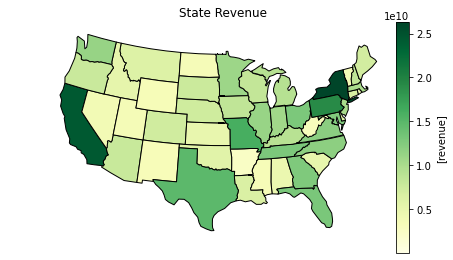

time: 849 ms (started: 2022-02-06 10:15:50 +00:00)


In [14]:
#!pip install cartopy
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
from matplotlib.colors import rgb2hex, Normalize
from matplotlib.colorbar import ColorbarBase
from matplotlib import cm
import numpy as np

fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1], projection=ccrs.LambertConformal())

ax.set_extent([-125, -66.5, 20, 50], ccrs.Geodetic())

shapename = 'admin_1_states_provinces_lakes'
states_shp = shpreader.natural_earth(resolution='110m',
                                     category='cultural', name=shapename)
ax.background_patch.set_visible(False)
ax.outline_patch.set_visible(False)

ax.set_title('State Revenue')

cmap = cm.get_cmap("YlGn")
min_val = min(state_rev.values())
max_val = max(state_rev.values())

for astate in shpreader.Reader(states_shp).records():

    ### You want to replace the following code with code that sets the
    ### facecolor as a gradient based on the population density above
    #facecolor = [0.9375, 0.9375, 0.859375]

    edgecolor = 'black'

    try:
        # use the name of this state to get pop_density
        rev_one_state = state_rev[ astate.attributes['postal'] ]
    except:
        rev_one_state = 0

    # `astate.geometry` is the polygon to plot
    ax.add_geometries([astate.geometry], ccrs.PlateCarree(),
                      facecolor=cmap(np.sqrt((rev_one_state-min_val)/(max_val-min_val)))[:3], edgecolor=edgecolor)
    
ax_c = fig.add_axes([0.9, 0.1, 0.03, 0.8])
norm = Normalize(vmin=min_val, vmax=max_val)
cb = ColorbarBase(ax_c,cmap=cmap,norm=norm,orientation='vertical',
                  label=r'[revenue]')


plt.show()